### Evaluating MMIDAS - Mouse smartseq data
This notebook guides you in evaluating MMIDAS in identifying meaningful cell types.

In [1]:
import os 
d = os.getcwd()
if d.endswith('MMIDAS'):
  pass
elif os.path.basename(os.path.dirname(d)) == 'MMIDAS':
  os.chdir('..')
elif 'MMIDAS' in os.listdir(d): 
  os.chdir('MMIDAS')

In [23]:
import glob
import pickle
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path

import mmidas
from mmidas.utils.tree_based_analysis import get_merged_types
from mmidas.cpl_mixvae import cpl_mixVAE
from mmidas.utils.tools import get_paths
from mmidas.utils.dataloader import load_data, get_loaders
from mmidas.utils.cluster_analysis import K_selection
from mmidas.utils.dataloader import load_data
from mmidas.eval_models import summarize_inference
import importlib

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [24]:
toml_file = 'pyproject.toml'
sub_file = 'mouse_smartseq'
config = get_paths(toml_file=toml_file, sub_file=sub_file)
dataset = 'mouse_smartseq'
data_path = config['paths']['main_dir'] / config[sub_file]['data_path']
data_file = data_path / config[sub_file]['anndata_file']
# data_file=Path(config[dataset]['data_path']) / Path(config[dataset]['anndata_file'])
data = load_data(datafile=data_file)

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/d2/Dist_MMIDAS/pyproject.toml
Getting files directories belong to mouse_smartseq...
data is loaded!
 --------- Data Summary --------- 
num cell types: 115, num cells: 22365, num genes:5032


In [34]:
saving_folder = config['paths']['main_dir'] / config[sub_file]['saving_path']
trained_model_folder = config[sub_file]['trained_model']
saving_folder = str(saving_folder / trained_model_folder)
trained_models = glob.glob(saving_folder + '/cpl_mixVAE_model_*')

In [46]:
type(trained_models[0])

str

##### Construct a cpl-mixVAE object and load the trained_model.

In [37]:
# TODO: just parse the file name to get these params

n_categories = 115 # upper bound of number of categories (clusters)
state_dim = 2 # continuous (state) variable dimensionality 
n_arm = 2 # number of arms
latent_dim = 10 # latent dimensionality of the model
trainloader, testloader, all_dataloader = get_loaders(dataset=data['log1p'], batch_size=5000, seed=0)

cplMixVAE = cpl_mixVAE(saving_folder=saving_folder, device='cpu')
cplMixVAE.init_model(n_categories=n_categories,
                     state_dim=state_dim,
                     input_dim=data['log1p'].shape[1],
                     lowD_dim=latent_dim,
                     n_arm=n_arm)

device: cpu
---> Using CPU!


## Model selection

##### Determining the sub-optimal number of clusters by leveraging consensus values across multiple pruning runs.
If you do not employ the pruning algorithm to determine the number of clusters, you can skip the following step.

In [6]:
import importlib 
importlib.reload(mmidas.eval_models)
from mmidas.eval_models import summarize_inference

# Loading trained models including before pruning and after pruning
cplMixVAE.variational = False
summary_dict = summarize_inference(cplMixVAE, trained_models, trainloader)

UnboundLocalError: local variable 'nprune_indx' referenced before assignment

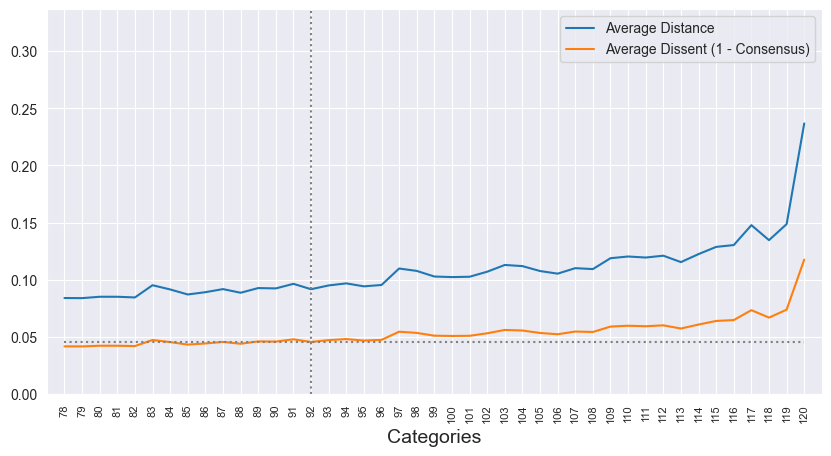

Selected number of clusters: 92 with consensus 0.954441573926868


In [6]:
# Plotting average consensus measure to select the number of clusters according to the minimum consensus measure, here 0.95

summary_file = saving_folder + f'/summary_performance_K_{n_categories}_narm_{n_arm}.p'
with open(summary_file, 'rb') as f:
    summary_dict = np.load(f, allow_pickle=True)
f.close()

model_order = K_selection(summary_dict, n_categories, n_arm, thr=0.95)

Assessing the performance of the model for the chosen model order, which denotes the dimensionality of the categorical representation in the mixture VAE model.

In [50]:
# selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_after_pruning_' + str(n_categories - model_order) + '*')[0]
model_order = n_categories
selected_model = glob.glob(saving_folder + '/cpl_mixVAE_model_*')[0]
outcome = summarize_inference(cplMixVAE, selected_model, testloader)

Model /cpl_mixVAE_model_before_pruning_A2_2024-08-05-00-28-54.pth


In [47]:
outcome['pred_label'][0]

array([[105.,  92.,  86., ...,  44.,   7.,   7.],
       [ 15.,  80.,  86., ...,  67., 105., 103.]])

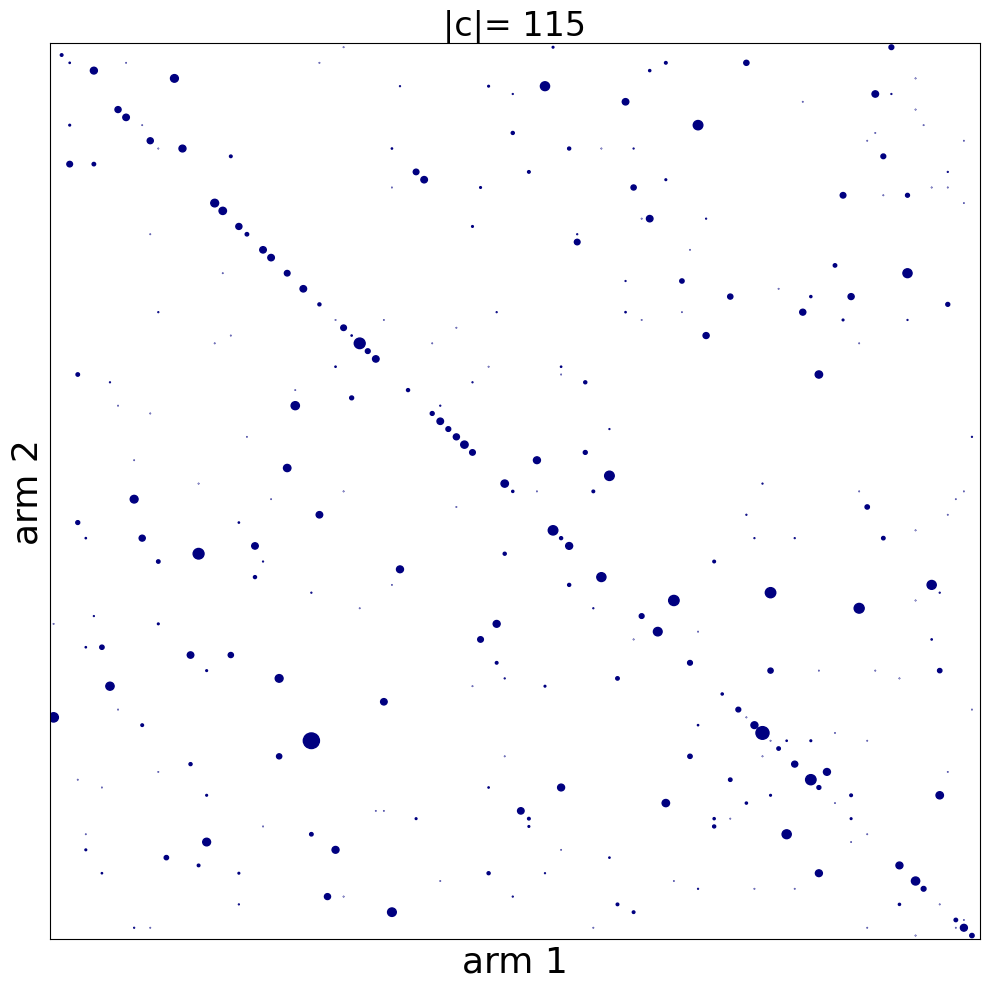

In [51]:
arm = 0
nprune_indx = outcome['nprune_indx']
armT_vs_armE = outcome['armA_vs_armB'][-1]
fig, axs = plt.subplots(1, 1, figsize=(10,10))
row_sum = armT_vs_armE.sum(axis=1)
confm_E = armT_vs_armE / row_sum[:, np.newaxis]
mtx = armT_vs_armE / np.max(armT_vs_armE) 
for l in range(model_order):
    for col in range(model_order):
        xy = np.array([col, l])
        axs.add_patch(plt.Circle(xy, radius=mtx[l, col], color='Navy'))
axs.set_xlim([-.5, model_order])
axs.set_ylim([-.5, model_order - .5])
axs.invert_yaxis()
axs.set_yticks([])
axs.set_xticks([])
axs.set_yticklabels([])
axs.set_xticklabels([])
plt.title('|c|= ' + str(armT_vs_armE.shape[0]), fontsize=24)
axs.set_xlabel('arm 1', fontsize=26)
axs.set_ylabel('arm 2', fontsize=26)
fig.tight_layout()
plt.savefig(saving_folder + f'/consensus_T1_vs_T2_K_{model_order}.png', dpi=600)

Average consensus on test cells: 0.31702581203181657


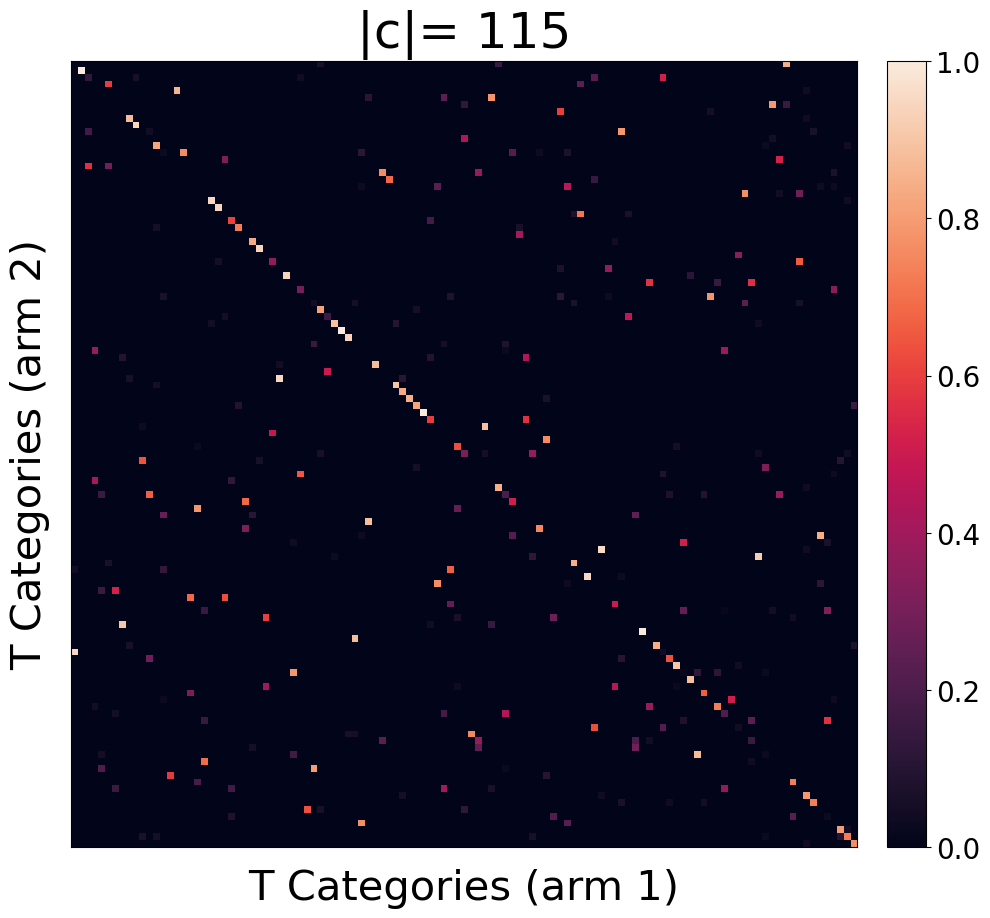

In [52]:
cons_mat = outcome['consensus'][0]

plt.figure(figsize=[10,10])
ax = plt.gca()
im = ax.imshow(cons_mat, cmap='rocket', vmin=0, vmax=1)
plt.xlabel('T Categories (arm 1)', fontsize=30, labelpad=15)
plt.ylabel('T Categories (arm 2)', fontsize=30, labelpad=15)
plt.xticks([])
plt.yticks([])
plt.title('|c|= ' + str(cons_mat.shape[0]), fontsize=36, pad=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)
cbar = plt.colorbar(im, cax=cax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(20)
cons_lam = np.mean(np.diag(cons_mat)) 

plt.tight_layout()
plt.savefig(saving_folder + f'/norm_consensus_T1_vs_T2_K_{model_order}.png', dpi=600)
print(f'Average consensus on test cells: {cons_lam}')

# maybe check images the model got wrong to see what features got wrong
# how much noise to give?

#### Evaluating the model results against a taxonomy
It necessitate access to a taxonomy for the dataset. Some of the subsequent steps depend on this taxonomy.

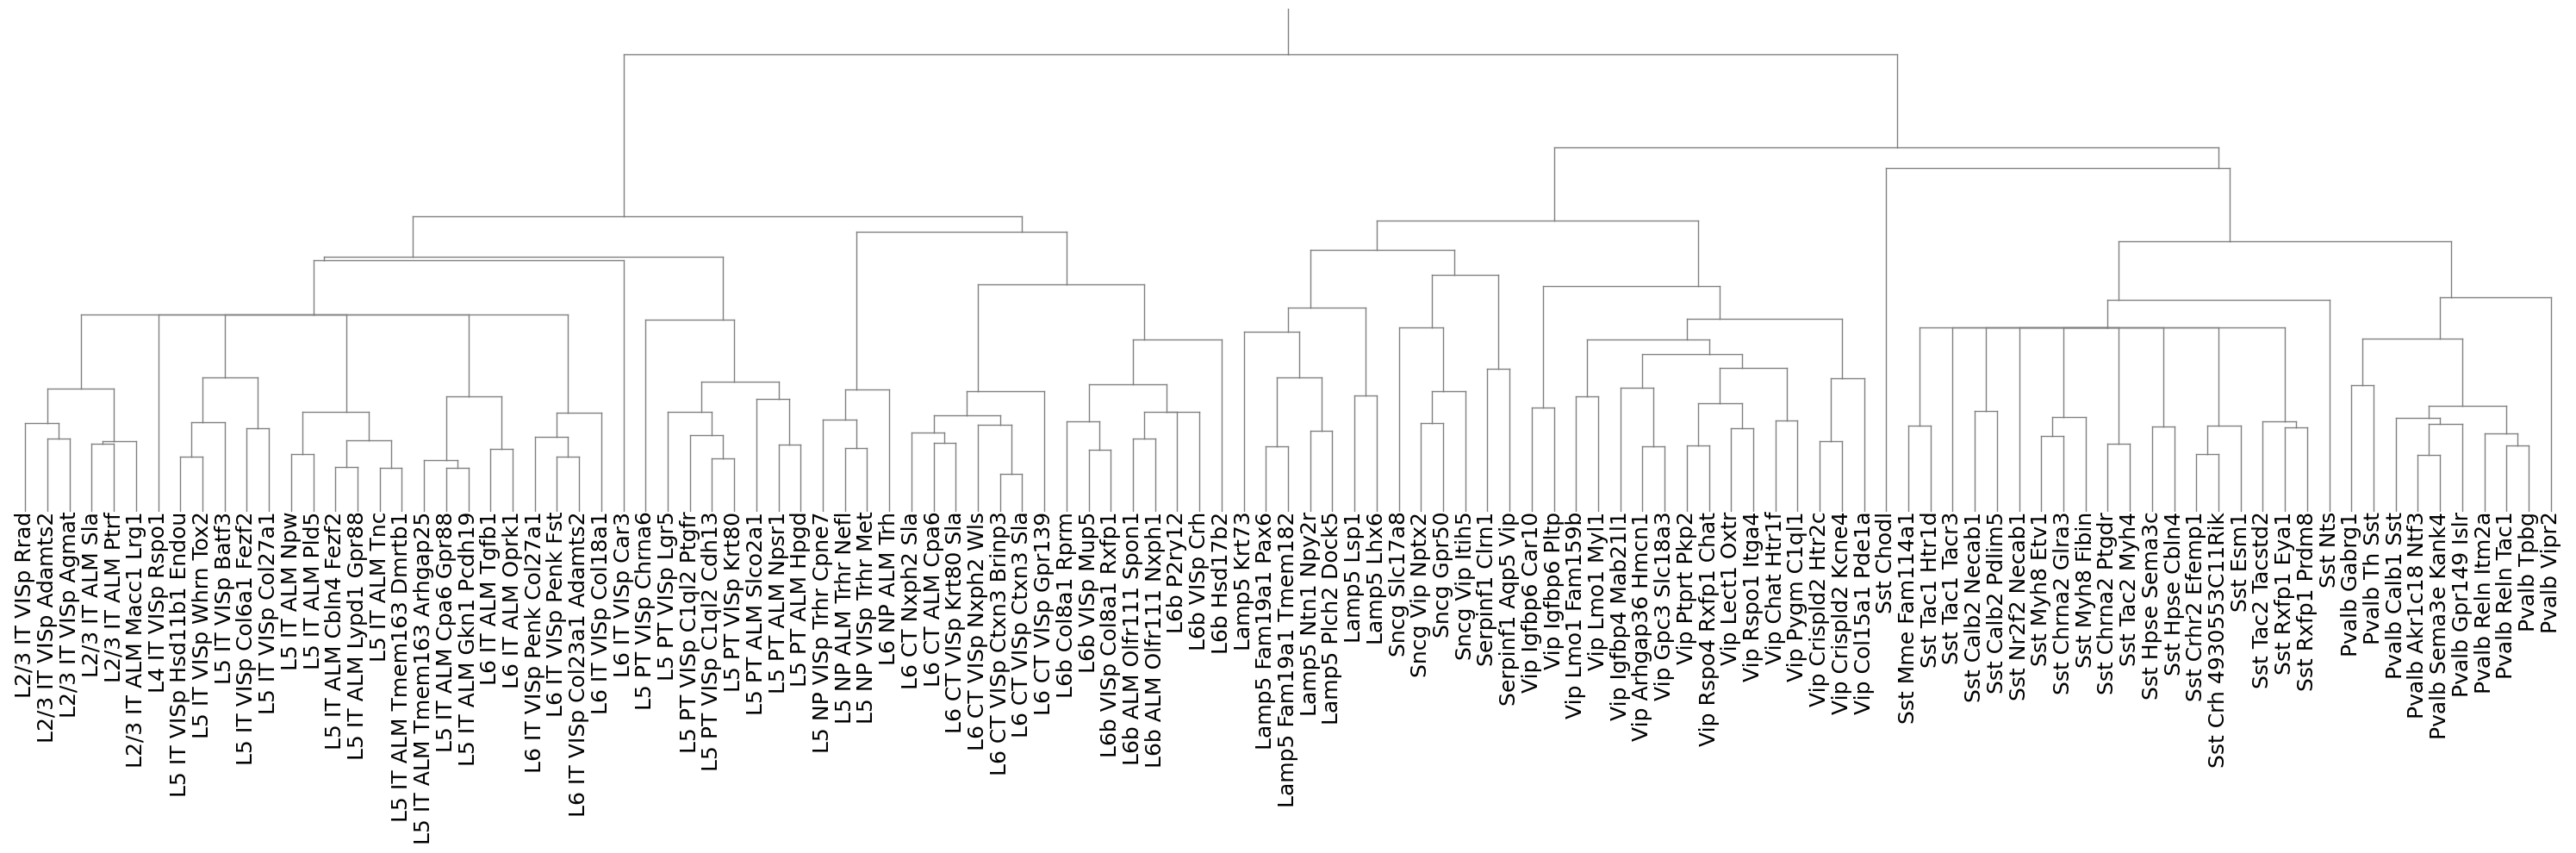

In [53]:
# Loading the taxonomy tree and ordering the clusters according to the tree
htree_file = data_path / config[sub_file]['htree_file']
data['cluster'] = np.array([c.strip() for c in data['cluster']])
T_class = np.unique(data['cluster'])
n_cluster = len(T_class)
merged_cells_labels, treeobj, _ = get_merged_types(htree_file=htree_file, cells_labels=data['cluster'], num_classes=1)
idd = []
for i, s in enumerate(treeobj.child):
    s = s.strip()
    if (T_class == s).any():
        cluster_id = list(T_class).index(s)
        idd.append(cluster_id)
        
T_class_ord = T_class[idd]

row_sort_T = []
for s in T_class_ord:
    row_sort_T.append(list(T_class).index(s))

row_sort_T = np.array(row_sort_T)

# Plotting the taxonomy tree
treeobj.plot(figsize=[30,10], txtleafonly=True, skeletononly=False, fontsize=18, skeletoncol='gray')

In [54]:
# Assign colors to each cell type according to the taxonomy
color_ord_T = treeobj.col[treeobj.isleaf]
color_T = treeobj.col[treeobj.isleaf]
data['cluster_color'] = np.array([color_ord_T[0]]*len(data['cluster']))
for i_type, ttype in enumerate(T_class):
    idx1 = np.where(data['cluster'] == ttype)[0]
    idx2 = np.where(T_class_ord == ttype)[0][0]
    data['cluster_color'][idx1] = color_ord_T[idx2]
    color_T[i_type] = color_ord_T[idx2]

In [55]:
outcome = summarize_inference(cplMixVAE, selected_model, all_dataloader)
category_vs_class = np.zeros((n_arm, data['n_type'], n_categories))

for arm in range(n_arm):
    label_predict = []
    for d in range(len(data['cluster_id'])):
        z_cat = np.squeeze(outcome['c_prob'][arm][d, :])
        category_vs_class[arm, int(data['cluster_id'][d] - 1), np.argmax(z_cat)] += 1
cT_vs_cT = category_vs_class[:, :, outcome['nprune_indx']]

Model /cpl_mixVAE_model_before_pruning_A2_2024-08-05-00-28-54.pth


#### t-types vs. MMIDAS categories

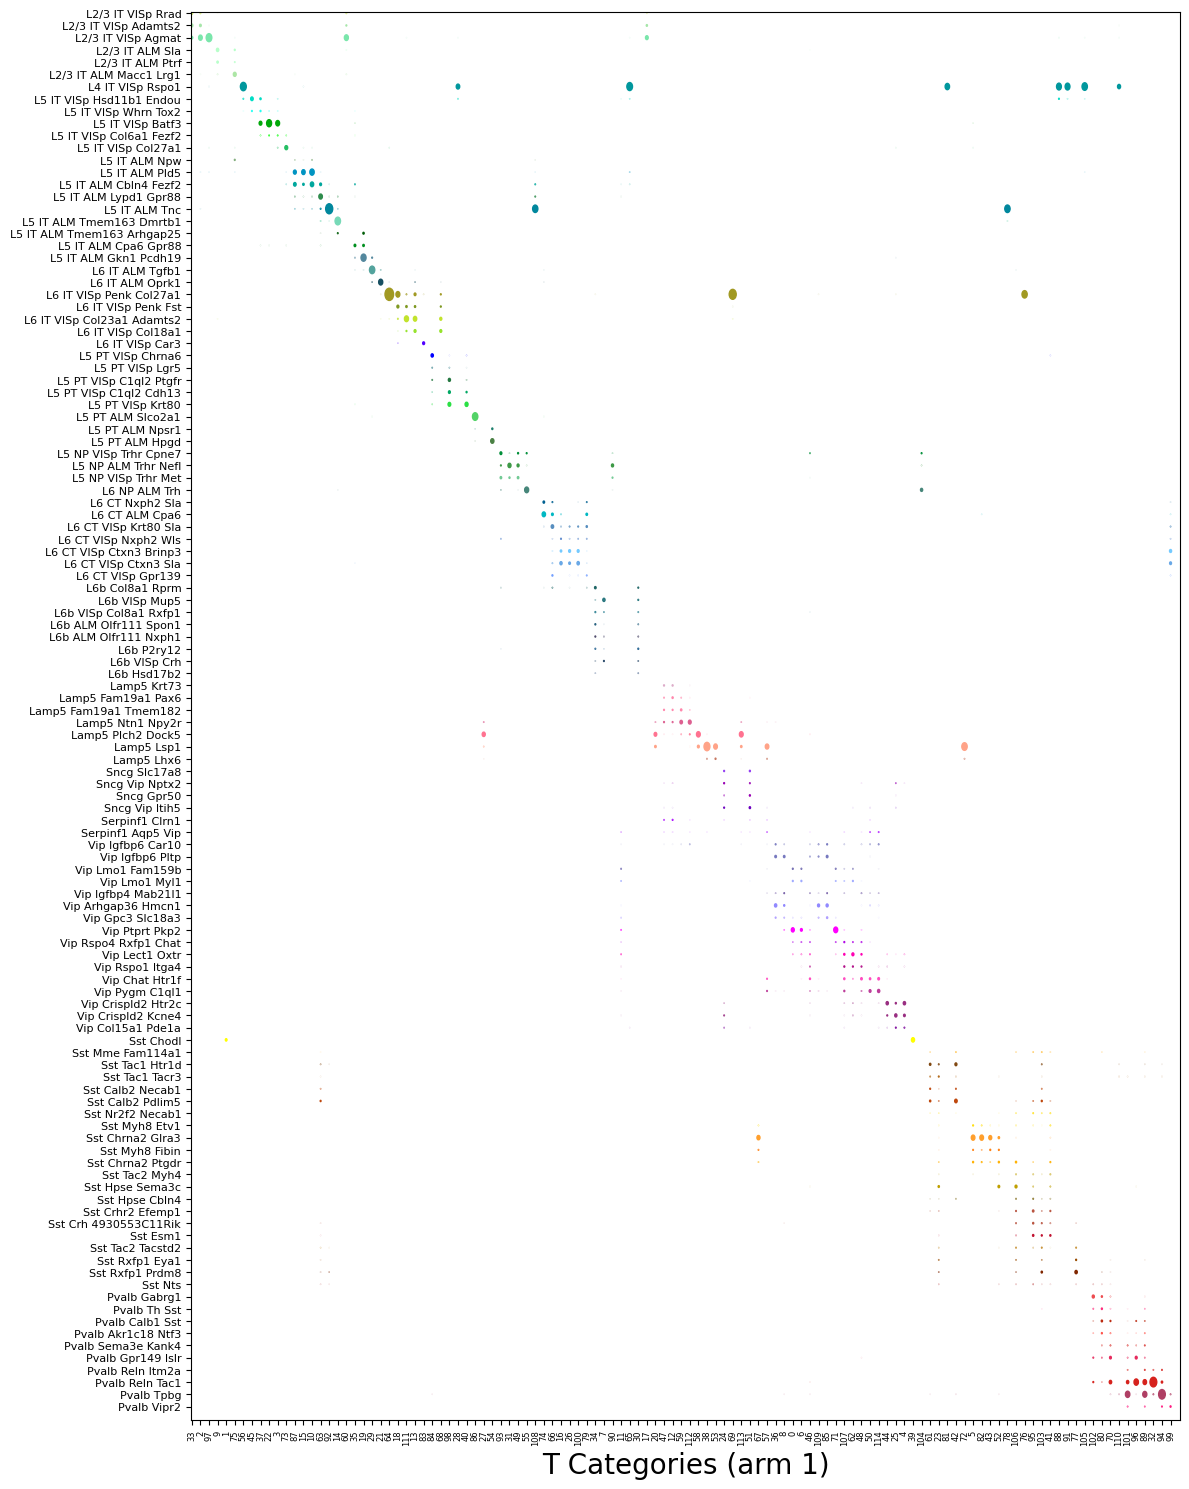

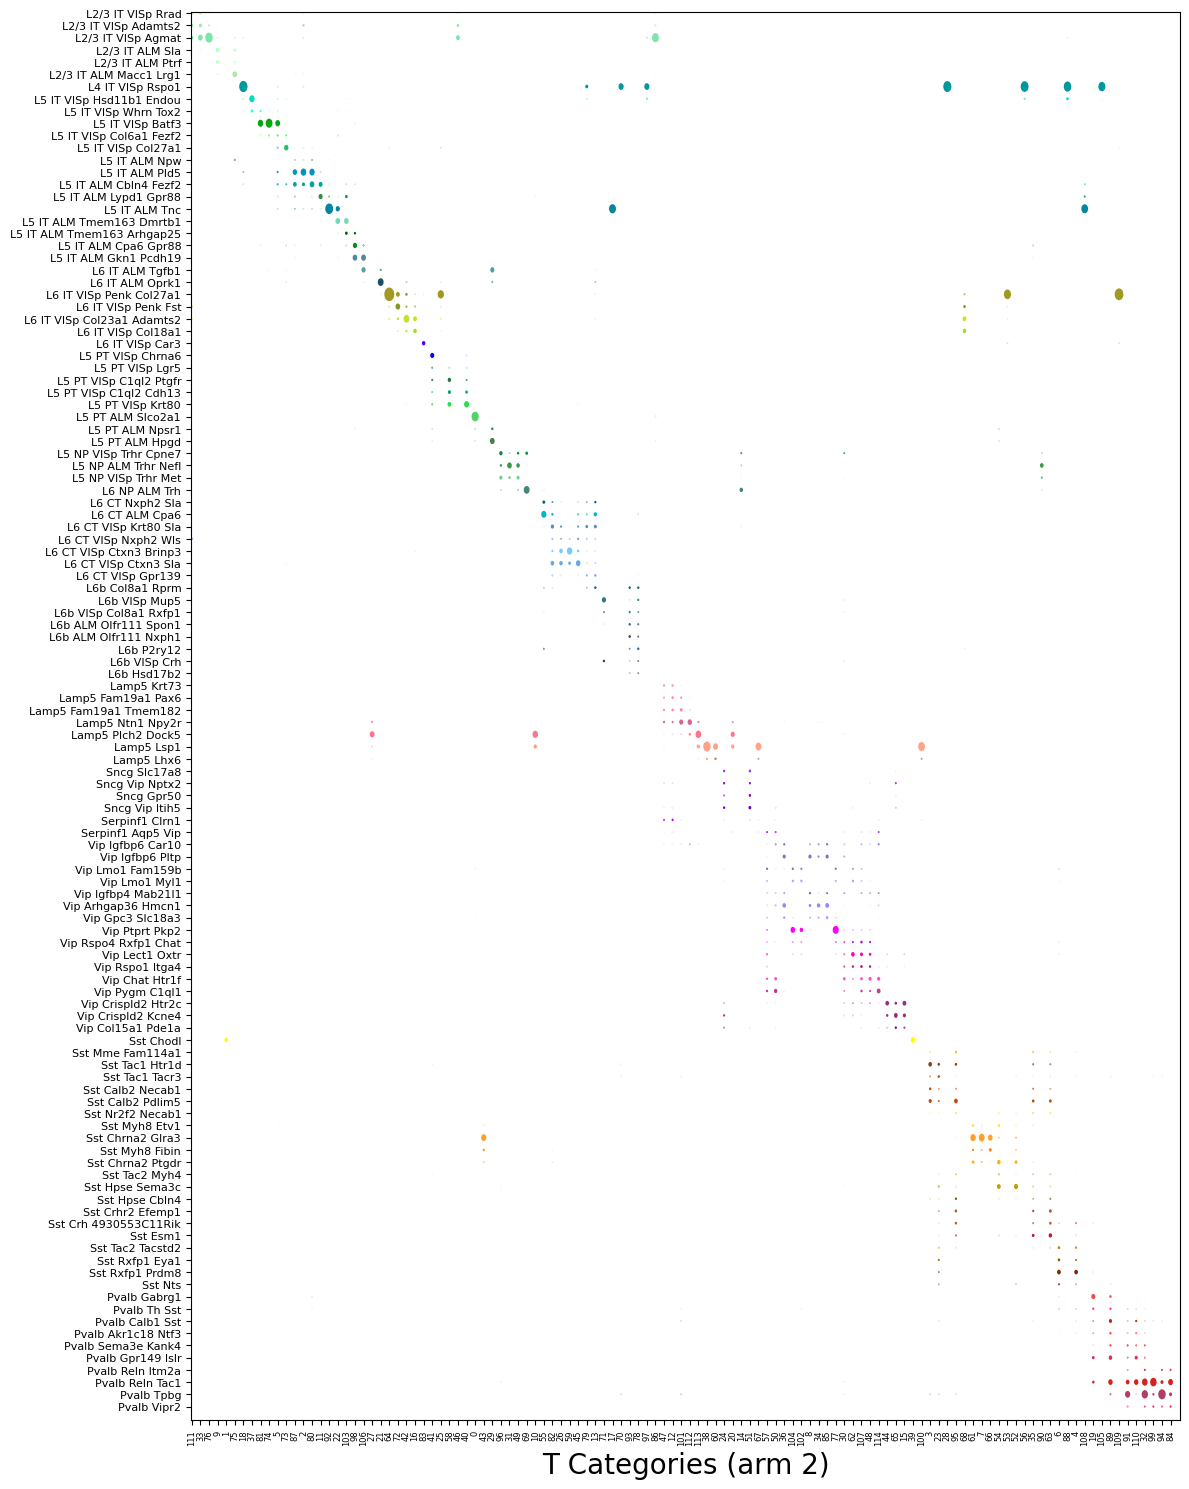

In [56]:
pruning_mask = outcome['nprune_indx']
confm_T, c_idx_T = [], []
for aT in range(n_arm):
    fig, axs = plt.subplots(1, 1, figsize=(12, 15), dpi=100)
    perform_mat_T = cT_vs_cT[aT, row_sort_T, :]
    row_sum = perform_mat_T.sum(axis=1)
    confm_T.append(np.divide(perform_mat_T, row_sum[:, np.newaxis], 
                        out=np.zeros_like(perform_mat_T), 
                        where=row_sum[:, np.newaxis]!=0))
    row_ind, col_ind = linear_sum_assignment(1 - perform_mat_T)

    sort_idx = [np.argsort(perform_mat_T[it, :])[::-1] for it in range(len(T_class_ord))]  
    sort_idx = np.vstack(sort_idx).astype(int)
    max_c_ind = -1 * np.ones(model_order) #sort_idx[:,0]
    if model_order > len(T_class_ord):
        not_used_cat = [a for a in range(model_order) if a not in sort_idx[:,0]]
        for cc in not_used_cat:
            colm = np.argmax(perform_mat_T[:, cc].astype(int))
            find_indx = np.where(sort_idx[colm,0] == sort_idx[:,0])[0][0]
            max_c_ind[find_indx+1] = cc
        max_c_ind[max_c_ind==-1] = sort_idx[:,0]
        cat_indx_T = max_c_ind.astype(int)
    else:
        cat_indx_T = col_ind # sort_idx[:, 0]
    
    c_idx_T.append(cat_indx_T)
    mtx = perform_mat_T[:, cat_indx_T] / np.max(perform_mat_T[:, cat_indx_T]) / 2
    for l in range(len(T_class_ord)):
        for col in range(model_order):
            xy = np.array([col, l])
            axs.add_patch(plt.Circle(xy, radius=(mtx[l, col]), color=color_ord_T[l]))
    axs.set_xlim([-.1, model_order+.1])
    axs.set_ylim([-.1, len(T_class_ord)+0.1])
    axs.invert_yaxis()
    axs.set_xlabel(f'T Categories (arm {aT+1})', fontsize=20)
    axs.set_xticks(np.arange(model_order))
    axs.set_xticklabels(pruning_mask[cat_indx_T], fontsize=6, rotation=90)
    axs.set_yticks(np.arange(len(T_class_ord)))
    axs.set_yticklabels(T_class_ord, fontsize=8)  
    fig.tight_layout()
    fig.savefig(saving_folder + f'/Taxonomy_vs_Tcat_arm_{aT}.pdf', dpi=600)

#### Mutual Information between t-types and MMIDAS categories

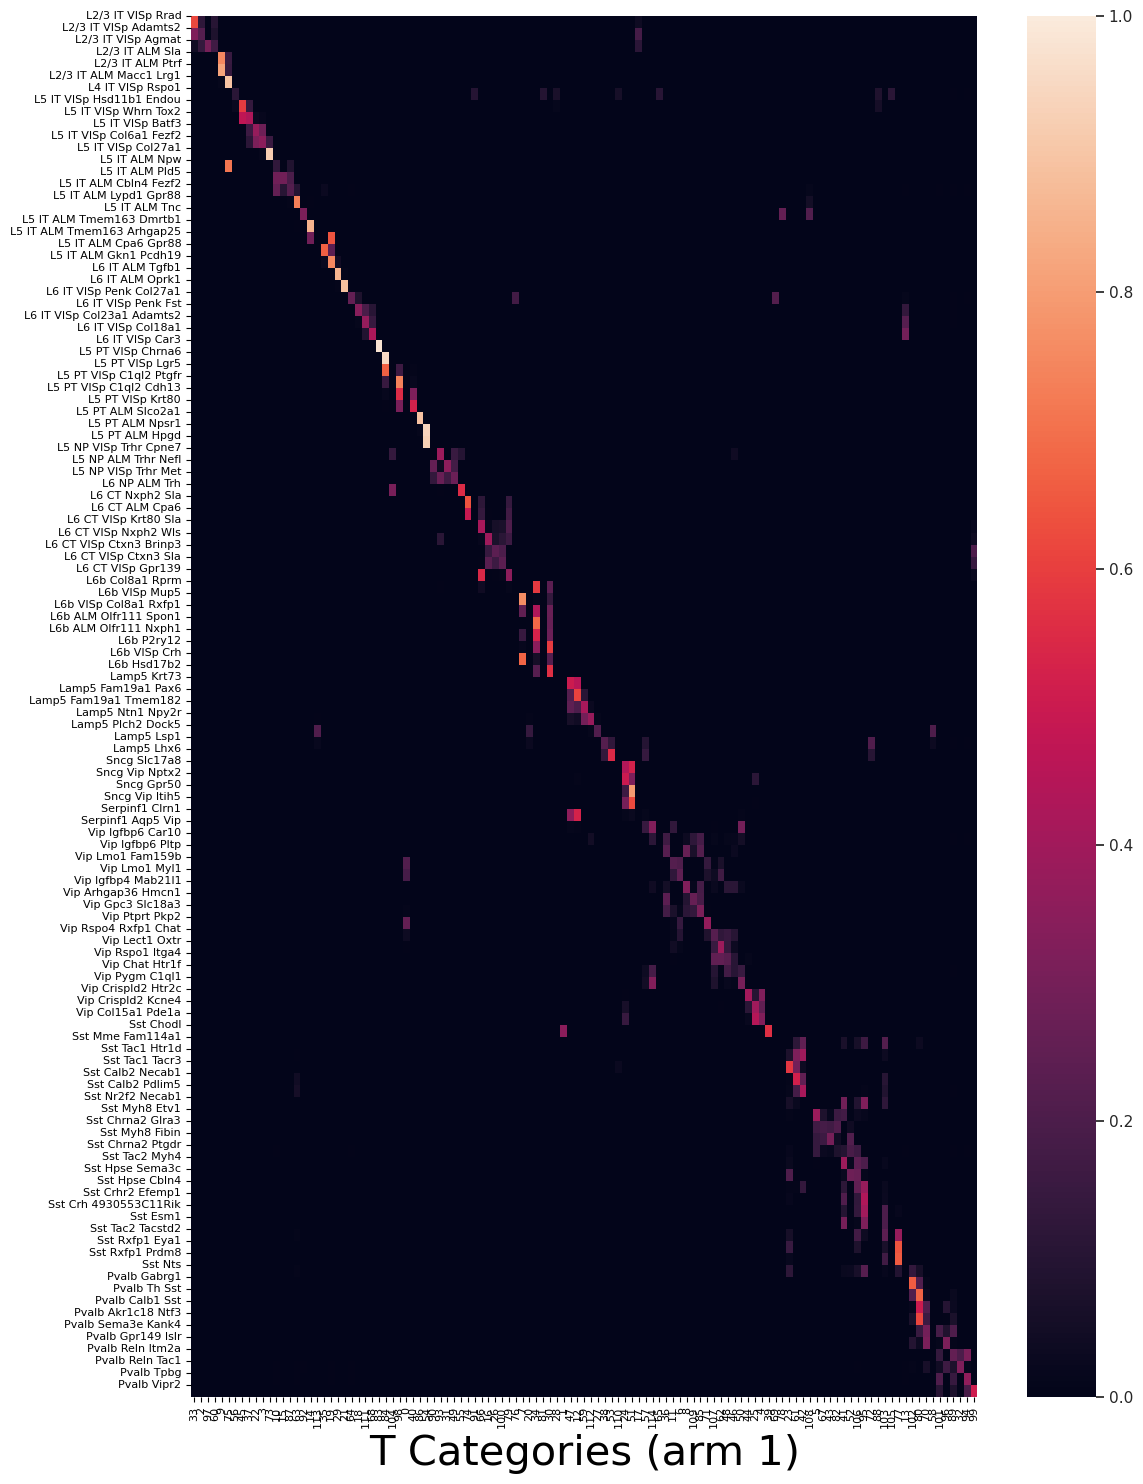

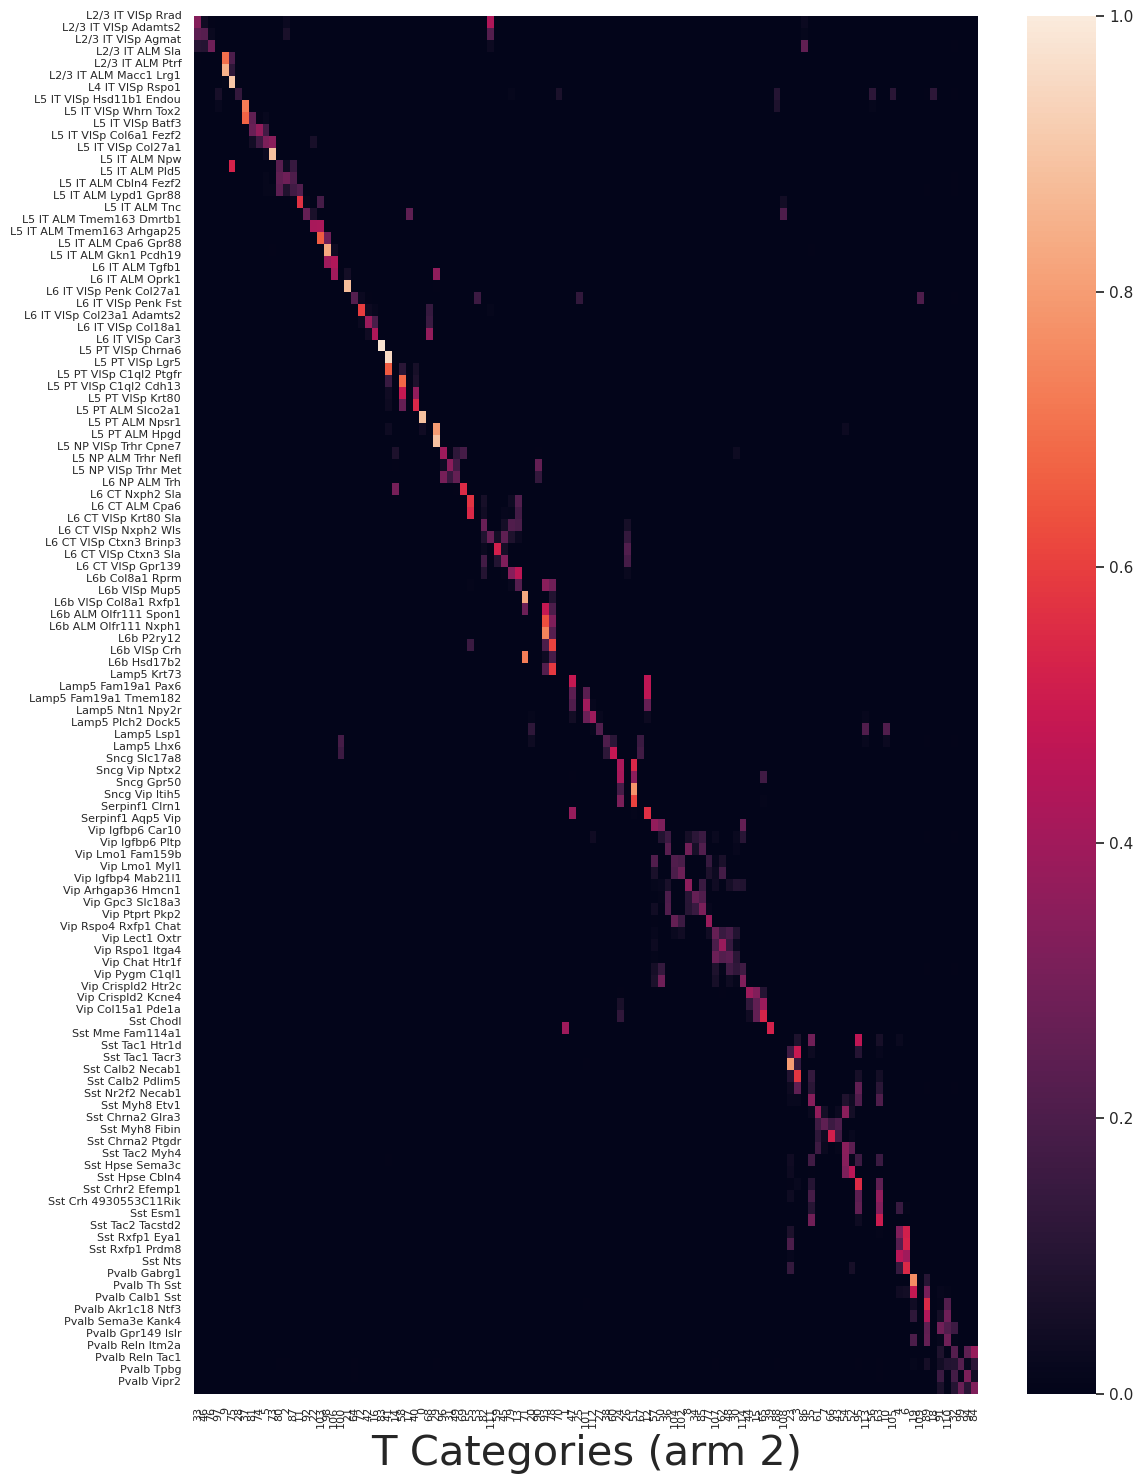

In [57]:
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import normalize

true_label = data['c_onehot'].astype(int)
mi_ind = []
pruning_mask = outcome['nprune_indx']

for arm in range(n_arm):
    fig, axs = plt.subplots(1, 1, figsize=(12, 15), dpi=100)
    sns.set(font_scale=1.)
    categories = np.argmax(outcome['c_prob'][arm], axis=1)
    uniq_categories = np.unique(categories)
    prediction = np.zeros(len(categories))
    mi_mat = np.zeros((n_cluster, model_order))

    for ic, c in enumerate(uniq_categories):
        tmp_idx = np.where(categories == c)[0]
        prediction[tmp_idx] = ic
    
    for c in range(model_order):
        per_c_label = np.zeros(len(true_label))
        per_c_label[prediction == c] = 1
        for f in range(n_cluster):
            mi_mat[f, c] = adjusted_mutual_info_score(true_label[:, f], per_c_label)

    mi_mat_norm = normalize(mi_mat, axis=1, norm='l1')
    mi_mat_norm = mi_mat_norm[row_sort_T, :]
    mi_row_ind, mi_col_ind = linear_sum_assignment(1 - mi_mat_norm)
    mi_ind.append(mi_col_ind)
    sns.heatmap(mi_mat_norm[:, mi_col_ind], xticklabels=pruning_mask[mi_col_ind], yticklabels=T_class_ord, 
                vmin=0, vmax=1, ax=axs, cbar_kws={"shrink": 1})
    axs.set_xlabel(f'T Categories (arm {arm+1})', fontsize=30)
    axs.set_yticks(np.arange(len(T_class_ord)))
    axs.set_yticklabels(T_class_ord, fontsize=8)  
    axs.set_xticklabels(axs.get_xticklabels(), fontsize=8)
    fig.tight_layout()
    plt.savefig(saving_folder + f'/MI_Taxonomy_vs_Tcat_K_{model_order}_arm_{arm}.png', dpi=600)

In [60]:
per_c_label[:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

0


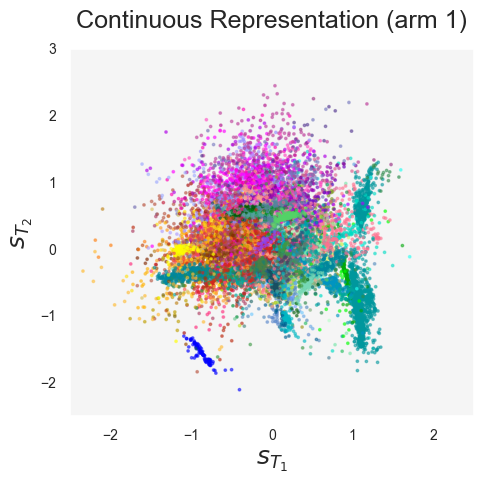

1


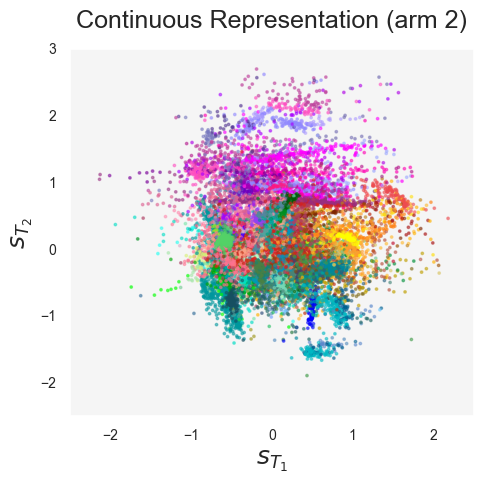

In [18]:
_, data_index = all_dataloader.dataset.tensors
data_index = data_index.numpy().astype(int)

for arm in range(n_arm):
    print(arm)
    plt.close('all')
    fig = plt.figure(figsize=(5, 5))
    m_size = 3
    alp = .5
    fontsize = 18

    sns.set_theme()
    sns.set(rc={'axes.facecolor':'whitesmoke'})

    if state_dim== 1:
        axs = fig.add_subplot(1, 1, 1)
        axs.hist(outcome['state_mu'][arm][:, 0], 
                 color=data['cluster_color'][data_index], s=m_size, alpha=alp)
        axs.set_xlabel(f'T_s_{0}')
    elif state_dim == 2:
        axs = fig.add_subplot(1,1,1)
        axs.scatter(outcome['state_mu'][arm][:, 0], outcome['state_mu'][arm][:, 1],
                   color=data['cluster_color'][data_index], s=m_size, alpha=alp)
        axs.set_xlabel(r'$s_{T_1}$', fontsize=fontsize)
        axs.set_ylabel(r'$s_{T_2}$', fontsize=fontsize)
        axs.xaxis.set_tick_params(labelsize=10)
        axs.yaxis.set_tick_params(labelsize=10)
    elif state_dim == 3:
        axs = fig.add_subplot(1,1,1, projection='3d')
        axs.scatter(outcome['state_mu'][arm][:, 0],
                   outcome['state_mu'][arm][:, 1],
                   outcome['state_mu'][arm][:, 2],
                   color=data['cluster_color'][data_index], s=m_size, alpha=alp)
        axs.set_xlabel(f'T_s_{0}')
        axs.set_ylabel(f'T_s_{1}')
        axs.set_zlabel(f'T_s_{2}')

    axs.set_ylim([-2.5, 3])
    axs.set_xlim([-2.5, 2.5])
    axs.set_title(f'Continuous Representation (arm {arm+1})', fontsize=18, pad=15)
    axs.grid(False)
    fig.tight_layout()
    plt.savefig(saving_folder + f'/state_mu_K_{model_order}_arm_{arm}.png', dpi=600)
    plt.show()